# Libraries to use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from scipy.stats import shapiro

# Read data from the csv 

In [40]:
df = pd.read_csv('pump_failure.csv')
df_1 = pd.DataFrame(df)

# Create new data frame
Here, we create a new data frame with the field "5min_step" that it is an step of 5 minutes length.

In [41]:
cdf = df_1
cdf['5min_step'] = np.arange(cdf.shape[0])

# Show the plot of the signal

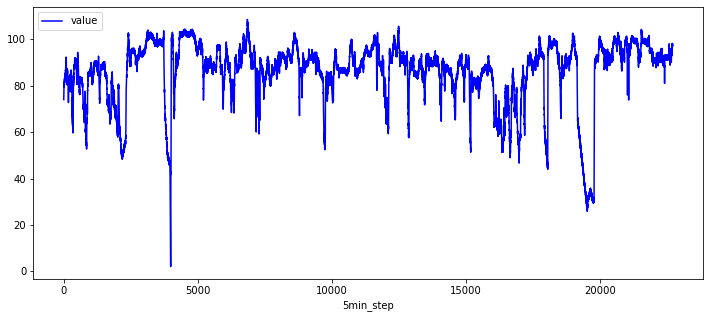

In [42]:
cdf.plot(kind = 'line', x = '5min_step', y = 'value', color = 'blue', figsize = (12,5))
plt.show()

# Statistics
Given the plot of the histogram we can consider by observation that it is not a Gaussian distribution and using the Shapiro-Wilk test evaluates the data and quantifies how likely it is that the data was drawn from a Gaussian distribution.

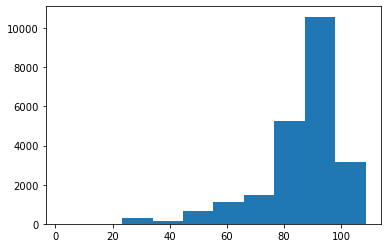

In [43]:
plt.hist(df.value)
plt.show()

In [44]:
stat, p = shapiro(df.value)
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretation
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Estadisticos=0.828, p=0.000
Sample does not look Gaussian (reject H0)


/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Create a function that computes the data quartile and return 1 for outlier data and 0 for not outlier
Given that a data set $N>30$ will approximate a normal distribution, we can use the interquartile range (IQR) method, we can identify the outliers in the data considering that the outliers are the observations that are below $lower = Q1 - 1.5*IQR$ or above $upper = Q1 + 1.5*IQR$ limits.

In [45]:
def find_anomalies_quantile(data):
    Q1 = cdf.value.quantile(0.25)
    Q3 = cdf.value.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q1 + 1.5*IQR

    if data > upper_limit or data < lower_limit:
        anomalies = 1
    else: 
        anomalies = 0
    return anomalies

# Create a function that computes the standar deviation and mean of the data for detection of anomalies and assign 1 for anomalie data and 0 for not anomalie
Another method is use the 3 sigma method that give us the $99.7%$ as a reliable data.

In [46]:
def find_anomalies_3s(random_data):
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(cdf.value)
    data_mean = np.mean(cdf.value)
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    if random_data > upper_limit or random_data < lower_limit:
        anomalies = 1
    else: 
        anomalies = 0
    return anomalies

# Apply the functions to our set

In [47]:
cdf['anomalies_quantile'] = cdf.apply(lambda row: find_anomalies_quantile(row['value']), axis=1)
cdf['anomalies_3s'] = cdf.apply(lambda row: find_anomalies_3s(row['value']), axis=1)

# Graph of both signals where the green region has the normal data and white region the anomalies
Given the law of large numbers, we can approximate our distribution to Gaussian distribution.

# Quartile method

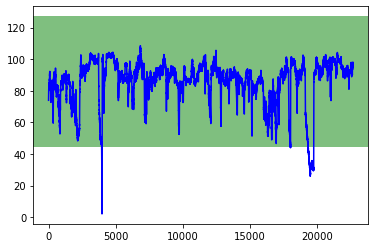

In [48]:
# Data to use
data_std = np.std(cdf.value)
data_mean = np.mean(cdf.value)
anomaly_cut_off = data_std * 3
lower_limit  = data_mean - anomaly_cut_off 
upper_limit = data_mean + anomaly_cut_off
x_values = cdf['5min_step'].tolist()
y_values = cdf['value'].tolist()

# Plot region
plt.axhspan(lower_limit, upper_limit, color='g', alpha=0.5, lw=0)
plt.plot(x_values, y_values, color='b')
plt.show()

# Quartile method

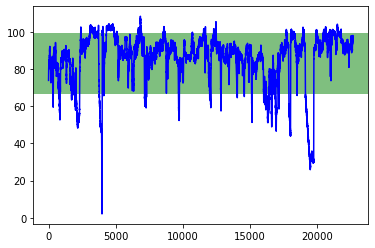

In [49]:
# Data to use
Q1 = df.value.quantile(0.25)
Q3 = df.value.quantile(0.75)
IQR = Q3 - Q1    
lower_limit = Q1 - 1.5*IQR
upper_limit = Q1 + 1.5*IQR
x_values = cdf['5min_step'].tolist()
y_values = cdf['value'].tolist()

# Plot region
plt.axhspan(lower_limit, upper_limit, color='g', alpha=0.5, lw=0)
plt.plot(x_values, y_values, color='b')
plt.show()

# Removing all the anomalies the plot looks like

In [54]:
# Filter anomalies
new_cdf_1 = cdf.loc[cdf.anomalies_quantile == 0]
new_cdf_2 = cdf.loc[cdf.anomalies_3s == 0]

In [55]:
# Define axis data quartiles method
x_values_1 = new_cdf_1['5min_step'].tolist()
y_values_1 = new_cdf_1['value'].tolist()

# Define axis data 3-sigmas method
x_values_2 = new_cdf_2['5min_step'].tolist()
y_values_2 = new_cdf_2['value'].tolist()

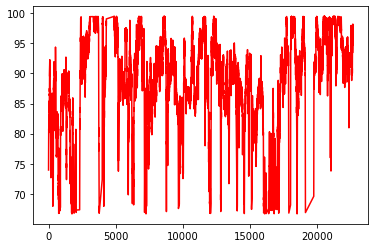

In [56]:
plt.plot(x_values_1, y_values_1, color='r')
plt.show()

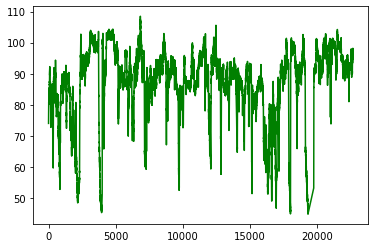

In [57]:
plt.plot(x_values_2, y_values_2, color='g')
plt.show()

# Prediction on the future
Given the data we load again the data with index of the column the date, where we observe that the data is stationary given de nature of their mean and standard deviaton

In [3]:
# load the data and drop NaN data 
dataset = pd.read_csv('pump_failure.csv', index_col = "timestamp", parse_dates = True)
dataset = dataset.dropna()

<AxesSubplot:xlabel='timestamp'>

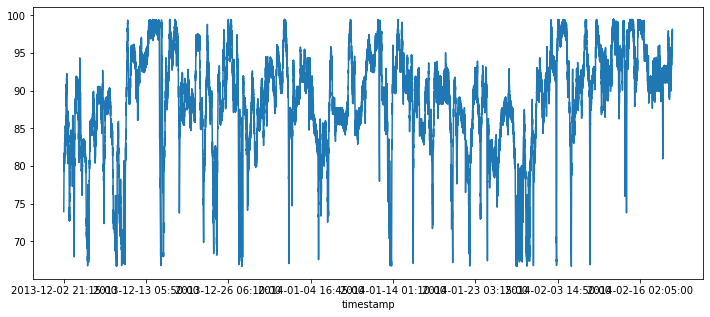

In [70]:
# Print our dataset by date
dataset["value"].plot(figsize = (12,5))

# Define a function to obtain the relevant statical parameters
This parameter help us to know if is stationary and given the value of the p-value we can say is stationary

In [71]:
# Load the stats librarie and import adfuller to obtain statistic parameters
from statsmodels.tsa.stattools import adfuller

In [72]:
# define the function with the relevant parameters
def ad_test(data):
    dftest = adfuller(data, autolag = "AIC")
    print(f"1. ADF: {dftest[0]}")
    print(f"2. p-value: {dftest[1]}")
    print(f"3. num of lags: {dftest[2]}")
    print(f"4. num of observations: {dftest[3]}")
    print(f"5. critical values: {dftest[3]}")
    for key, val in dftest[4].items():
        print("\t", f"{key}:{val}")

In [73]:
# print the relevant parameters
ad_test(dataset["value"])

1. ADF: -8.965781810232265
2. p-value: 7.996647088834396e-15
3. num of lags: 20
4. num of observations: 18465
5. critical values: 18465
	 1%:-3.4307041949257613
	 5%:-2.861696540991937
	 10%:-2.566853322617148


# ARIMA model to predict the data in future

In [74]:
# load the librarie for the arima model and obtain the best model
from pmdarima import auto_arima

# We look for the best model
In these case is the (1,1,2)

In [75]:
stepwise_fit = auto_arima(dataset["value"], trace = True, supress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51229.344, Time=5.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53773.138, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51921.099, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52107.997, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53771.164, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51236.470, Time=3.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51882.576, Time=5.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=51238.476, Time=18.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51230.582, Time=10.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51914.286, Time=1.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=51228.953, Time=5.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=51448.357, Time=2.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=51230.456, Time=6.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51751.205, Time=1.76 sec
 ARIMA(0,1,4)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18486
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -25608.492
Date:                Wed, 05 Jan 2022   AIC                          51226.983
Time:                        23:09:56   BIC                          51266.107
Sample:                             0   HQIC                         51239.832
                              - 18486                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6963      0.020     34.194      0.000       0.656       0.736
ma.L1         -1.0402      0.021    -49.660      0.000      -1.081      -0.999
ma.L2          0.3408      0.013     26.067      0.000       0.315       0.366
ma.L3          0.0292      0.009      3.148      0.002       0.011       0.047
sigma2         0.9350      0.008    122.204      0.000       0.920       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9744.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.49
Prob(H) (two-sided):                  0.28   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# Load the stats librarie and import ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# We split the data into trainig and testing

In [77]:
# define the dataset to train and tets
train = dataset
test = dataset

In [78]:
# Load the stats librarie and import SARIMAX model, because the ARIMA model have been removed, but the SARIMAX is the same that ARIMA where order 0,0,0
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [83]:
# instant the model
model = SARIMAX(train["value"], order = (1,1,2))
model = model.fit()
model.summary()

/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has bee

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                18486
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -25613.250
Date:                Wed, 05 Jan 2022   AIC                          51234.500
Time:                        23:11:13   BIC                          51265.799
Sample:                             0   HQIC                         51244.779
                              - 18486                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7376      0.014     53.355      0.000       0.711       0.765
ma.L1         -1.0884      0.012    -88.435      0.000      -1.113      -1.064
ma.L2          0.3782      0.005     70.702      0.000       0.368       0.389
sigma2         0.9355      0.007    124.824      0.000       0.921       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):             10007.00
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.50
Prob(H) (two-sided):                  0.29   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start = start, end = end, type = "levels")
print(pred)

/Users/gabolb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


18486    97.195273
18487    97.116885
18488    97.036696
18489    96.980856
18490    96.941972
           ...    
36967    96.852803
36968    96.852803
36969    96.852803
36970    96.852803
36971    96.852803
Name: predicted_mean, Length: 18486, dtype: float64


<AxesSubplot:xlabel='timestamp'>

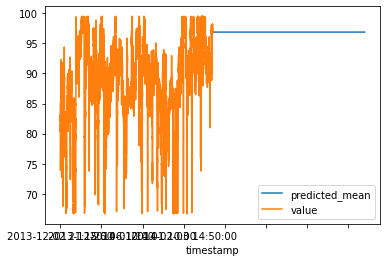

In [81]:
pred.plot(legend = True)
test["value"].plot(legend = True)

# Future data

Here missing the failure prediction, nevertheless, it can be obtained using predictive models, as an example we can predict with the anomalies the failures and use the SMOTE algorithm to classificated the faiulures and with a dataset of testing obtain the false negatives, false positives, etc..., then predict the accuracy of our model using statistics